 # Churn for Bank Customers

### Introduction

The aim of this notebook is to predict customer churn in a bank using diffent techniques of data balancing. We will also check how categorizing the data affects performance of models for this particular dataset.

SMOTE(Synthetic Minority Oversampling Technique) is a technique to up-sample the minority classes while avoiding overfitting. It does this by generating new synthetic examples close to the other points (belonging to the minority class) in feature space.

Resampling - technique to decrease the number of majority class by drawing randomly desired number of samples and up-sample  minority class by copying samples from non-dominating class

Dataset downloaded from https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers

In [1]:
#imports

#General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#models
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
import lightgbm as lgb

#preprocess
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample

#metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#other
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


In [2]:
# initialize variables for test size and ranndom state
TEST_SIZE = 0.3
SEED = 42

In [3]:
def get_pipeline(transformer=None, resample=None, scaler=None, model=None):
    # return pipeline with passed steps
    
    pipeline = Pipeline(
    [('transformer', transformer),
     ('resample', resample),
     ("scaler", scaler),      
     ("model", model)
     ])
    
    return pipeline

In [4]:
def fit_model(pipeline, X_train, X_test, y_train,):
    # fit pipeline and return tuple with
    # predicted values for train set, predicted values for test set, model name used in pipeline
    
    pipeline.fit(X_train, y_train)
    
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)
    
    return (pipeline.predict(X_train), pipeline.predict(X_test), pipeline.named_steps['model'])

In [5]:
def print_metrics(model_name, y_pred_train, y_pred_test, y_train, y_test):
    # print classification report, confusion matrix, f1 score for tets and train sets
    
    print(f'Model {model_name} train results:\n')
    print(classification_report(y_train,  y_pred_train))
    print('F1 score for training set:'+'{}\n'.format(f1_score(y_train,  y_pred_train)))
        
    print('CONFUSION MATRIX\n')
    ConfusionMatrixDisplay.from_predictions(y_train,  y_pred_train, normalize='all', display_labels=['Stay', 'Churn']);
    plt.show()
  
    print(f'\nModel {model_name} TEST results:\n')
    print(classification_report(y_test,  y_pred_test))
    
    print('F1 score for test set:'+'{}\n'.format(f1_score(y_test,  y_pred_test))) 
    
    print('CONFUSION MATRIX\n')
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='all', display_labels=['Stay', 'Churn']);
    plt.show()
    
    
    print("----------------------------------------------\n")

In [6]:
#load dataset
data = pd.read_csv("Churn_Modeling.csv")

In [7]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### EDA

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [9]:
#no missing values
data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [10]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [8]:
#Data are imbalanced
data["Exited"].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

<AxesSubplot:>

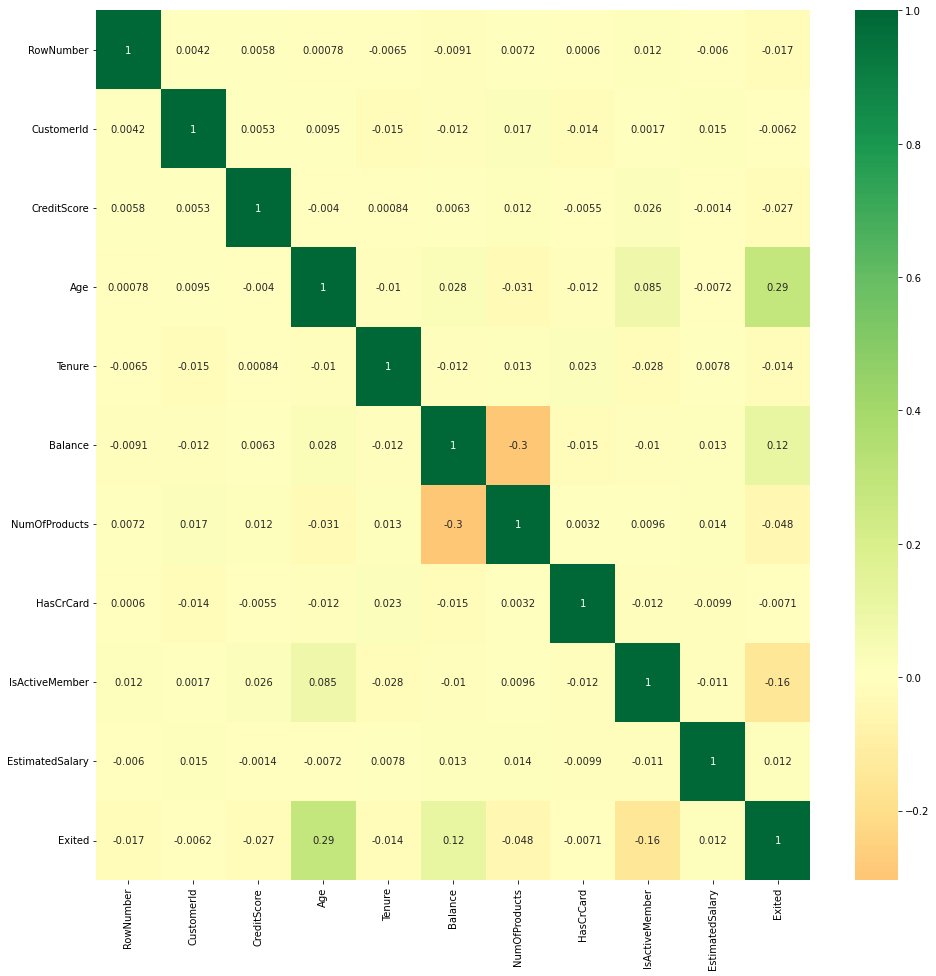

In [9]:
# we can observe no strong correlation between features
plt.figure(figsize=(16, 16))
sns.heatmap(data.corr(), 
                 cmap='RdYlGn', 
                 center=0, 
                 annot=True)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:156: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:156: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:156: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:156: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


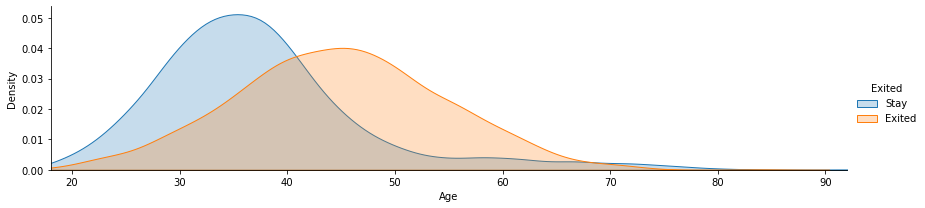

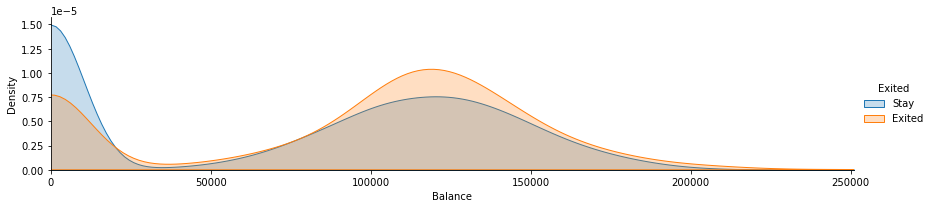

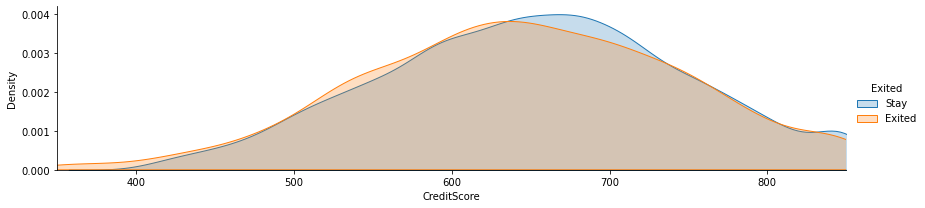

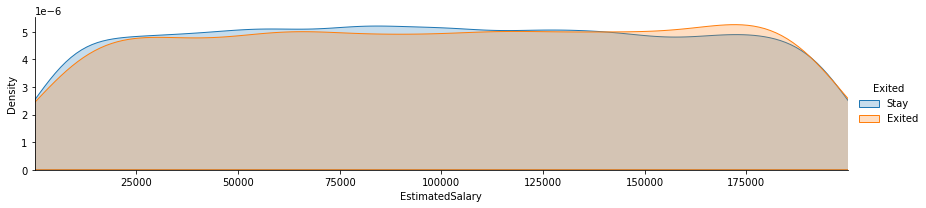

In [10]:
#Churn probality is higher for customers aged between 40 and 60 and for accounts with balance between 100 000 and 150 000

columns = ['Age', 'Balance', 'CreditScore', 'EstimatedSalary']

for col in columns:
    
    FacetGrid = sns.FacetGrid(data, hue='Exited', aspect=4)
    FacetGrid.map(sns.kdeplot, col, shade=True)
    FacetGrid.set(xlim=(data[col].min(), data[col].max()))
    FacetGrid.add_legend(labels=['Stay', "Exited"])

<AxesSubplot:xlabel='HasCrCard', ylabel='count'>

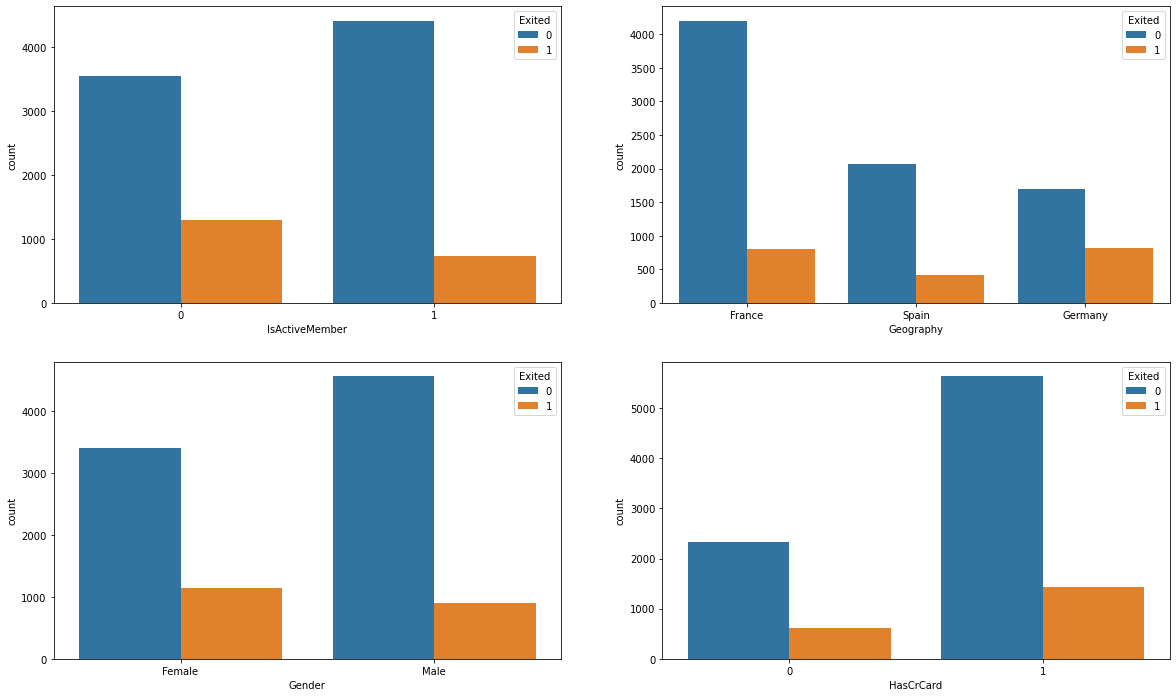

In [11]:
#churn rate is higher for not active members, Germans and females
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='IsActiveMember', hue = 'Exited',data = data, ax=axarr[0][0])
sns.countplot(x="Geography", hue="Exited", data=data, ax=axarr[0][1])
sns.countplot(x="Gender", hue="Exited", data=data, ax=axarr[1][0])
sns.countplot(x="HasCrCard", hue="Exited", data=data, ax=axarr[1][1])


<AxesSubplot:xlabel='Tenure', ylabel='count'>

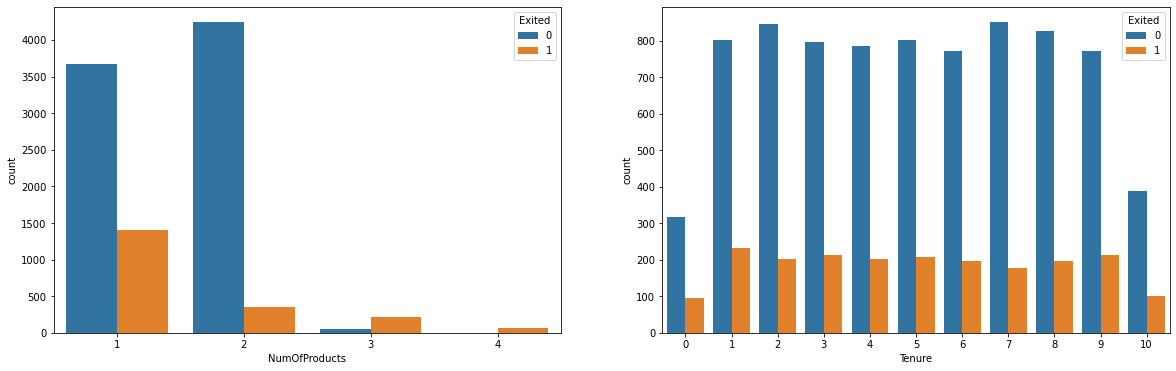

In [12]:
#customers with 1 product seemms to churn more often
fig, axarr = plt.subplots(1, 2, figsize=(20, 6))
sns.countplot(x="NumOfProducts", hue="Exited", data=data, ax=axarr[0])
sns.countplot(x="Tenure", hue="Exited", data=data, ax=axarr[1])

### Data preprocessing

In [14]:
# Initialize objects useful in data preprocessong and model fitting

#OneHot Encoding
transformer = OneHotEncoder(drop='first', sparse=False)
clm_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(drop='first', sparse=False),[1,2])], remainder='passthrough')

#SMOTE
smote = SMOTE(random_state=SEED) # k_neighbors=4,

#Scaling
scaler_mas = MaxAbsScaler()

#Model
svc = LinearSVC(max_iter=1000, random_state=SEED)
dtclf = DecisionTreeClassifier(random_state=SEED)
rfclf = RandomForestClassifier(random_state=SEED)
lgbmc = lgb.LGBMClassifier(random_state=SEED)

In [15]:
# list of models for pipeline
model_list = [svc, dtclf, rfclf, lgbmc]

## Model fitting with raw data

In [16]:
data_raw = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [17]:
y_raw = data_raw.pop('Exited')
X_raw = data_raw

X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(
 X_raw, y_raw, test_size=TEST_SIZE, random_state=SEED, stratify=y_raw)

In [13]:
X_raw.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


Model LinearSVC(random_state=42) train results:

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      5574
           1       0.62      0.12      0.20      1426

    accuracy                           0.81      7000
   macro avg       0.72      0.55      0.54      7000
weighted avg       0.77      0.81      0.75      7000

F1 score for training set:0.19905771495877503

CONFUSION MATRIX



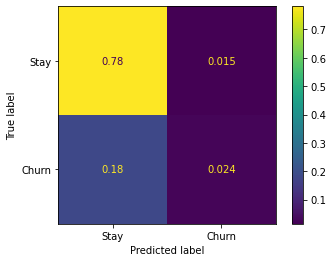


Model LinearSVC(random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      2389
           1       0.70      0.14      0.24       611

    accuracy                           0.81      3000
   macro avg       0.76      0.56      0.56      3000
weighted avg       0.79      0.81      0.76      3000

F1 score for test set:0.2364130434782609

CONFUSION MATRIX



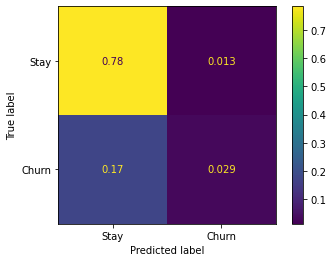

----------------------------------------------

Model DecisionTreeClassifier(random_state=42) train results:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5574
           1       1.00      1.00      1.00      1426

    accuracy                           1.00      7000
   macro avg       1.00      1.00      1.00      7000
weighted avg       1.00      1.00      1.00      7000

F1 score for training set:1.0

CONFUSION MATRIX



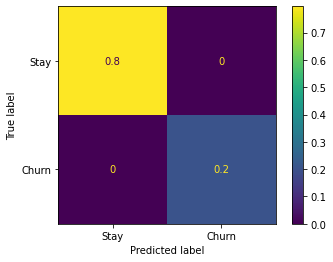


Model DecisionTreeClassifier(random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2389
           1       0.49      0.50      0.49       611

    accuracy                           0.79      3000
   macro avg       0.68      0.68      0.68      3000
weighted avg       0.79      0.79      0.79      3000

F1 score for test set:0.4935064935064935

CONFUSION MATRIX



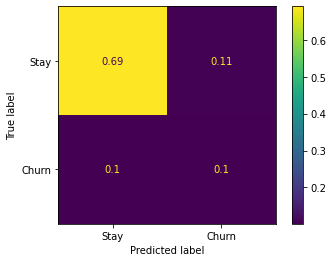

----------------------------------------------

Model RandomForestClassifier(random_state=42) train results:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5574
           1       1.00      1.00      1.00      1426

    accuracy                           1.00      7000
   macro avg       1.00      1.00      1.00      7000
weighted avg       1.00      1.00      1.00      7000

F1 score for training set:0.999649245878639

CONFUSION MATRIX



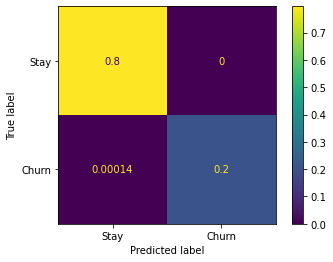


Model RandomForestClassifier(random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2389
           1       0.78      0.48      0.60       611

    accuracy                           0.87      3000
   macro avg       0.83      0.72      0.76      3000
weighted avg       0.86      0.87      0.85      3000

F1 score for test set:0.5959595959595959

CONFUSION MATRIX



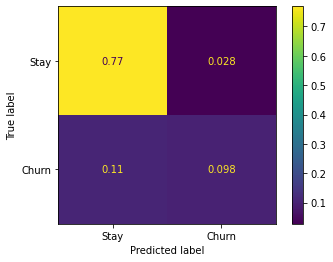

----------------------------------------------

Model LGBMClassifier(random_state=42) train results:

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      5574
           1       0.92      0.65      0.76      1426

    accuracy                           0.92      7000
   macro avg       0.92      0.82      0.86      7000
weighted avg       0.92      0.92      0.91      7000

F1 score for training set:0.7621776504297995

CONFUSION MATRIX



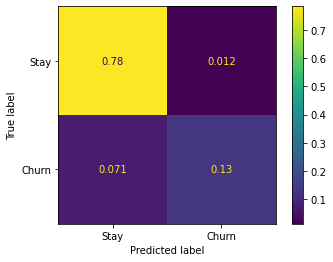


Model LGBMClassifier(random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2389
           1       0.76      0.50      0.61       611

    accuracy                           0.87      3000
   macro avg       0.82      0.73      0.76      3000
weighted avg       0.86      0.87      0.86      3000

F1 score for test set:0.6074950690335306

CONFUSION MATRIX



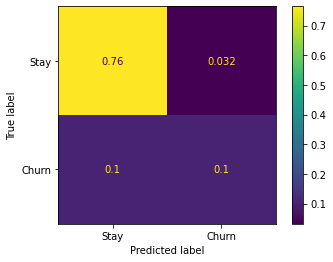

----------------------------------------------



In [14]:
for model in model_list:
    
    pipeline = get_pipeline(transformer=clm_transformer, scaler=scaler_mas, model=model)

    y_pred_train, y_pred_test, model_name = fit_model(pipeline, X_raw_train, X_raw_test, y_raw_train)
    
    print_metrics(model_name, y_pred_train, y_pred_test, y_raw_train, y_raw_test)

- SVC model has very poor performance
- Tree based models are strongly overfitted

### SMOTE model fitting with raw data

In [18]:
smote_param_grid = {"resample__sampling_strategy":[0.3, 0.4, 0.5, 0.6],
                    "resample__k_neighbors":[2, 5, 7, 10, 15],
                    }

SMOTE(random_state=42, sampling_strategy=0.6)
Model LinearSVC(random_state=42) train results:

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      5574
           1       0.46      0.50      0.48      1426

    accuracy                           0.78      7000
   macro avg       0.66      0.67      0.67      7000
weighted avg       0.79      0.78      0.78      7000

F1 score for training set:0.477088948787062

CONFUSION MATRIX



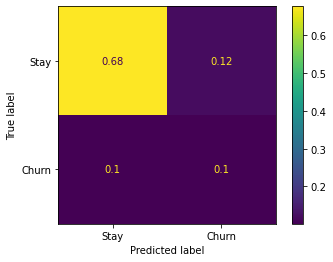


Model LinearSVC(random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      2389
           1       0.50      0.52      0.51       611

    accuracy                           0.80      3000
   macro avg       0.69      0.70      0.69      3000
weighted avg       0.80      0.80      0.80      3000

F1 score for test set:0.512

CONFUSION MATRIX



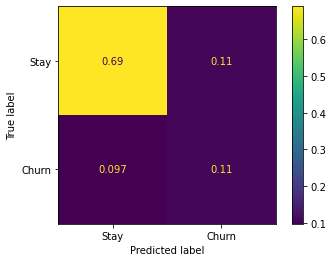

----------------------------------------------

SMOTE(k_neighbors=10, random_state=42, sampling_strategy=0.6)
Model DecisionTreeClassifier(random_state=42) train results:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5574
           1       1.00      1.00      1.00      1426

    accuracy                           1.00      7000
   macro avg       1.00      1.00      1.00      7000
weighted avg       1.00      1.00      1.00      7000

F1 score for training set:1.0

CONFUSION MATRIX



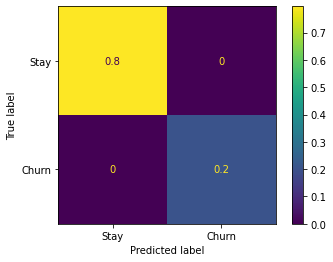


Model DecisionTreeClassifier(random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      2389
           1       0.48      0.56      0.51       611

    accuracy                           0.79      3000
   macro avg       0.68      0.70      0.69      3000
weighted avg       0.80      0.79      0.79      3000

F1 score for test set:0.5143288084464556

CONFUSION MATRIX



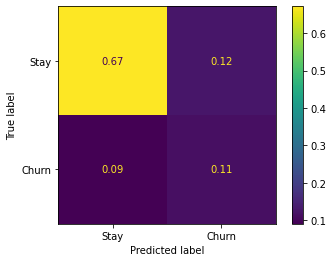

----------------------------------------------

SMOTE(k_neighbors=2, random_state=42, sampling_strategy=0.6)
Model RandomForestClassifier(random_state=42) train results:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5574
           1       1.00      1.00      1.00      1426

    accuracy                           1.00      7000
   macro avg       1.00      1.00      1.00      7000
weighted avg       1.00      1.00      1.00      7000

F1 score for training set:1.0

CONFUSION MATRIX



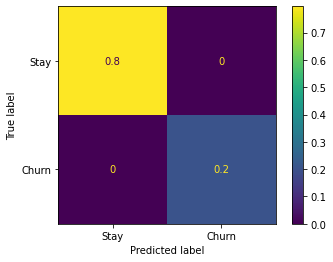


Model RandomForestClassifier(random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2389
           1       0.75      0.51      0.61       611

    accuracy                           0.87      3000
   macro avg       0.82      0.73      0.76      3000
weighted avg       0.86      0.87      0.86      3000

F1 score for test set:0.6062378167641326

CONFUSION MATRIX



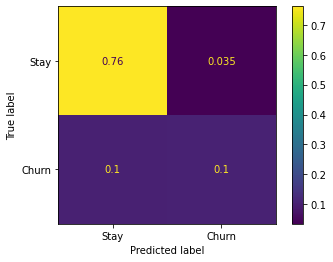

----------------------------------------------

SMOTE(k_neighbors=10, random_state=42, sampling_strategy=0.4)
Model LGBMClassifier(random_state=42) train results:

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      5574
           1       0.91      0.66      0.76      1426

    accuracy                           0.92      7000
   macro avg       0.91      0.82      0.86      7000
weighted avg       0.92      0.92      0.91      7000

F1 score for training set:0.7628361858190709

CONFUSION MATRIX



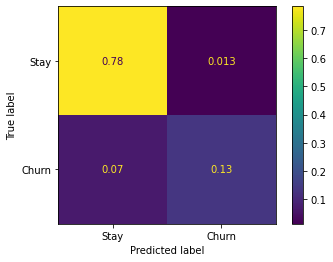


Model LGBMClassifier(random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2389
           1       0.76      0.52      0.62       611

    accuracy                           0.87      3000
   macro avg       0.82      0.74      0.77      3000
weighted avg       0.86      0.87      0.86      3000

F1 score for test set:0.6161321671525753

CONFUSION MATRIX



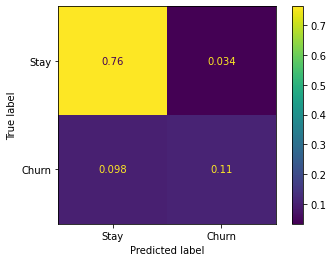

----------------------------------------------



In [19]:
for model in model_list:
    
    pipeline = get_pipeline(transformer=clm_transformer, scaler=scaler_mas, resample = smote, model=model)
    
    smote_Grid = GridSearchCV(pipeline, smote_param_grid, cv=10, scoring="f1", refit=True, n_jobs=-1)
    smote_Grid.fit(X_raw_train, y_raw_train)
    
    best_estimator = smote_Grid.best_estimator_
    
    y_pred_train, y_pred_test, model_name = fit_model(best_estimator, X_raw_train, X_raw_test, y_raw_train)
    
    print(best_estimator.named_steps['resample'])
    print_metrics(model_name, y_pred_train, y_pred_test, y_raw_train, y_raw_test)

- f1 score for each model has increased
- Tree based models still remain overfitted

### Model fitting with resample (raw data)

In [20]:
data_majority = data[data["Exited"] == 0]
data_minority = data[data["Exited"] == 1]

majority_samples = int(data["Exited"].value_counts()[0] * 0.7)
minority_samples = int(data["Exited"].value_counts()[1] * 1.3)

In [21]:
data_majority_downsampled = resample(data_majority, 
                                 replace=False,    
                                 n_samples=majority_samples,  
                                 random_state=SEED)

data_minority_upsampled = resample(data_minority, 
                                 replace=True,
                                 n_samples=minority_samples,
                                 random_state=SEED) 
 

# Combine majority class with upsampled minority class
data_raw_resampled = pd.concat([data_majority_downsampled, data_minority_upsampled])
 
# Display new class counts
data_raw_resampled['Exited'].value_counts()

0    5574
1    2648
Name: Exited, dtype: int64

In [22]:
data_raw_resampled = data_raw_resampled.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [23]:
y_resampled_raw = data_raw_resampled.pop('Exited')
X_resampled_raw = data_raw_resampled

X_resampled_raw_train, X_resampled_raw_test, y_resampled_raw_train, y_resampled_raw_test = train_test_split(
 X_resampled_raw, y_resampled_raw, test_size=TEST_SIZE, random_state=SEED, stratify=y_resampled_raw)

Model LinearSVC(random_state=42) train results:

              precision    recall  f1-score   support

           0       0.76      0.90      0.82      3902
           1       0.65      0.40      0.50      1853

    accuracy                           0.74      5755
   macro avg       0.71      0.65      0.66      5755
weighted avg       0.73      0.74      0.72      5755

F1 score for training set:0.49632107023411365

CONFUSION MATRIX



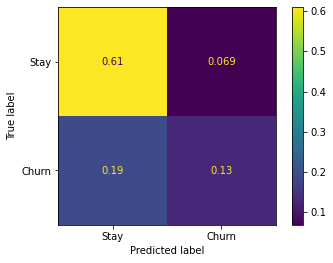


Model LinearSVC(random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.76      0.90      0.82      1672
           1       0.65      0.41      0.50       795

    accuracy                           0.74      2467
   macro avg       0.71      0.65      0.66      2467
weighted avg       0.73      0.74      0.72      2467

F1 score for test set:0.5023183925811437

CONFUSION MATRIX



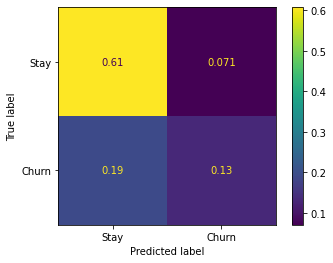

----------------------------------------------

Model DecisionTreeClassifier(random_state=42) train results:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3902
           1       1.00      1.00      1.00      1853

    accuracy                           1.00      5755
   macro avg       1.00      1.00      1.00      5755
weighted avg       1.00      1.00      1.00      5755

F1 score for training set:1.0

CONFUSION MATRIX



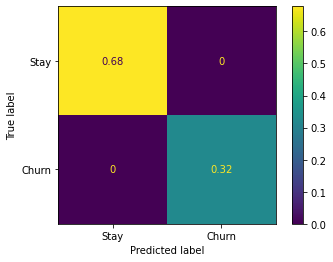


Model DecisionTreeClassifier(random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.91      0.83      0.87      1672
           1       0.69      0.83      0.75       795

    accuracy                           0.83      2467
   macro avg       0.80      0.83      0.81      2467
weighted avg       0.84      0.83      0.83      2467

F1 score for test set:0.7544565842438182

CONFUSION MATRIX



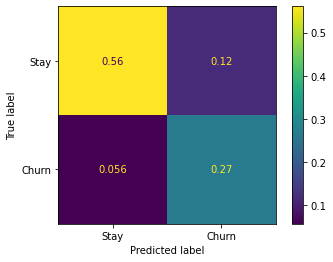

----------------------------------------------

Model RandomForestClassifier(random_state=42) train results:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3902
           1       1.00      1.00      1.00      1853

    accuracy                           1.00      5755
   macro avg       1.00      1.00      1.00      5755
weighted avg       1.00      1.00      1.00      5755

F1 score for training set:1.0

CONFUSION MATRIX



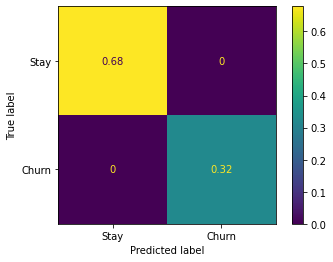


Model RandomForestClassifier(random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1672
           1       0.87      0.82      0.84       795

    accuracy                           0.90      2467
   macro avg       0.89      0.88      0.88      2467
weighted avg       0.90      0.90      0.90      2467

F1 score for test set:0.8415584415584415

CONFUSION MATRIX



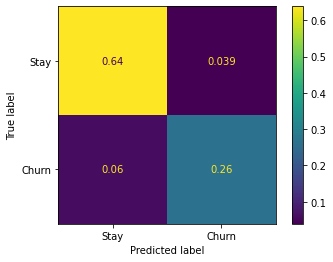

----------------------------------------------

Model LGBMClassifier(random_state=42) train results:

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      3902
           1       0.92      0.85      0.88      1853

    accuracy                           0.93      5755
   macro avg       0.93      0.91      0.92      5755
weighted avg       0.93      0.93      0.93      5755

F1 score for training set:0.8845181230682776

CONFUSION MATRIX



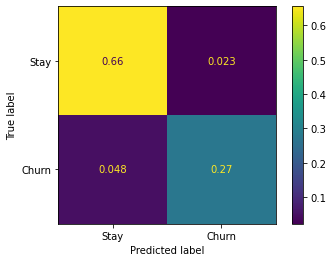


Model LGBMClassifier(random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1672
           1       0.81      0.73      0.76       795

    accuracy                           0.86      2467
   macro avg       0.84      0.82      0.83      2467
weighted avg       0.85      0.86      0.85      2467

F1 score for test set:0.7647448641484427

CONFUSION MATRIX



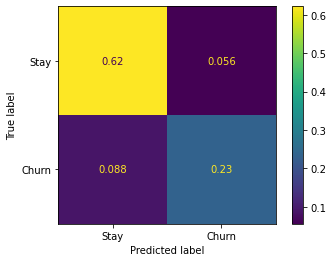

----------------------------------------------



In [24]:
for model in model_list:

    pipeline = get_pipeline(transformer=clm_transformer, scaler=scaler_mas, model=model)
    
    y_pred_train, y_pred_test, model_name = fit_model(pipeline, X_resampled_raw_train, X_resampled_raw_test, y_resampled_raw_train)
    
    print_metrics(model_name, y_pred_train, y_pred_test, y_resampled_raw_train, y_resampled_raw_test)
    

- SVC model shows weaker performance than SMOTE rebalanced model
- Applyting resampling resulted in increased f1 score (over 75 %) for tree based model
- Models are still overfitted

## Model fitting with data categorization

Lets check if categorizing data can increase models performance

In [25]:
#create category bins

data['Credit_bins'] = pd.cut(x=data["CreditScore"], bins=[200, 550, 750, 900])

data['Age_bins'] = pd.cut(x=data["Age"], bins=[17, 40, 50, 60, 100])

data['Balance_bins'] = pd.cut(x=data["Balance"], bins=[-1, 50000, 100000, 150000, 200000, 251000])

data['Salary_bins'] = pd.cut(x=data["EstimatedSalary"], 
                            bins=np.linspace(data["EstimatedSalary"].min() - 1, data["EstimatedSalary"].max() + 1,
                            num=5, dtype=int))


data["NumOfProducts"] = data['NumOfProducts'].apply(lambda x: x if x < 2 else 2)

<AxesSubplot:xlabel='Age_bins', ylabel='count'>

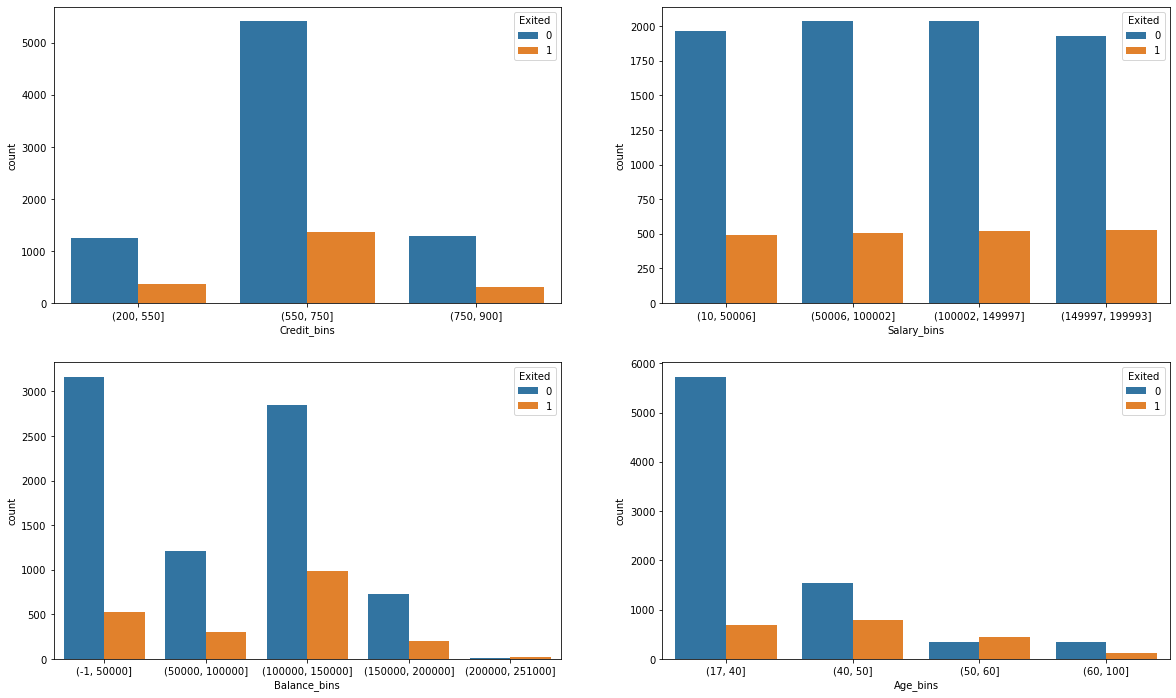

In [30]:
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x="Credit_bins", hue = "Exited",data = data, ax=axarr[0][0])
sns.countplot(x="Salary_bins", hue="Exited", data=data, ax=axarr[0][1])
sns.countplot(x="Balance_bins", hue="Exited", data=data, ax=axarr[1][0])
sns.countplot(x="Age_bins", hue ="Exited",data = data, ax=axarr[1][1])

In [31]:
data_model = data.drop(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary'], axis=1)

In [32]:
y = data_model.pop('Exited')
X = data_model

X_train, X_test, y_train, y_test = train_test_split(
 X, y, test_size=TEST_SIZE, random_state=SEED, stratify=y)


In [33]:
X.head()

,Geography,Gender,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Credit_bins,Age_bins,Balance_bins,Salary_bins
0,France,Female,2,1,1,1,"(550, 750]","(40, 50]","(-1, 50000]","(100002, 149997]"
1,Spain,Female,1,1,0,1,"(550, 750]","(40, 50]","(50000, 100000]","(100002, 149997]"
2,France,Female,8,2,1,0,"(200, 550]","(40, 50]","(150000, 200000]","(100002, 149997]"
3,France,Female,1,2,0,0,"(550, 750]","(17, 40]","(-1, 50000]","(50006, 100002]"
4,Spain,Female,2,1,1,1,"(750, 900]","(40, 50]","(100000, 150000]","(50006, 100002]"


### Initial model fitting

Model LinearSVC(random_state=42) train results:

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      5574
           1       0.71      0.26      0.38      1426

    accuracy                           0.83      7000
   macro avg       0.77      0.62      0.64      7000
weighted avg       0.81      0.83      0.79      7000

F1 score for training set:0.3840653728294178

CONFUSION MATRIX



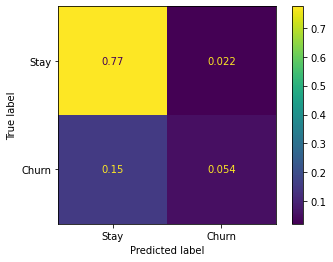


Model LinearSVC(random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.84      0.98      0.90      2389
           1       0.76      0.28      0.41       611

    accuracy                           0.84      3000
   macro avg       0.80      0.63      0.66      3000
weighted avg       0.83      0.84      0.80      3000

F1 score for test set:0.4095808383233533

CONFUSION MATRIX



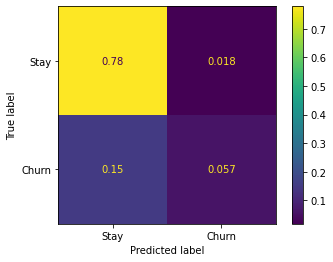

----------------------------------------------

Model DecisionTreeClassifier(random_state=42) train results:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5574
           1       0.99      0.86      0.92      1426

    accuracy                           0.97      7000
   macro avg       0.98      0.93      0.95      7000
weighted avg       0.97      0.97      0.97      7000

F1 score for training set:0.9222139117427075

CONFUSION MATRIX



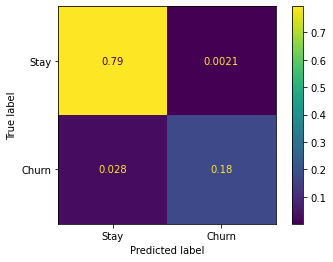


Model DecisionTreeClassifier(random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2389
           1       0.42      0.43      0.42       611

    accuracy                           0.76      3000
   macro avg       0.64      0.64      0.64      3000
weighted avg       0.77      0.76      0.76      3000

F1 score for test set:0.424390243902439

CONFUSION MATRIX



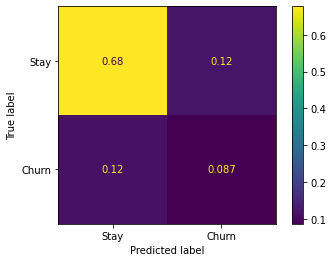

----------------------------------------------

Model RandomForestClassifier(random_state=42) train results:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5574
           1       0.96      0.89      0.92      1426

    accuracy                           0.97      7000
   macro avg       0.97      0.94      0.95      7000
weighted avg       0.97      0.97      0.97      7000

F1 score for training set:0.9243085880640466

CONFUSION MATRIX



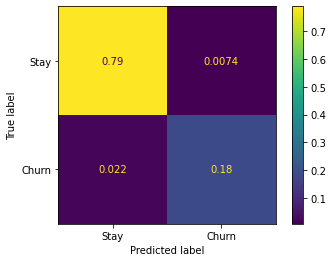


Model RandomForestClassifier(random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      2389
           1       0.58      0.36      0.45       611

    accuracy                           0.82      3000
   macro avg       0.72      0.65      0.67      3000
weighted avg       0.80      0.82      0.80      3000

F1 score for test set:0.44601412714429867

CONFUSION MATRIX



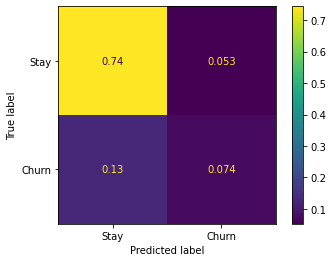

----------------------------------------------

Model LGBMClassifier(random_state=42) train results:

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      5574
           1       0.80      0.44      0.57      1426

    accuracy                           0.86      7000
   macro avg       0.83      0.70      0.74      7000
weighted avg       0.86      0.86      0.85      7000

F1 score for training set:0.5656108597285068

CONFUSION MATRIX



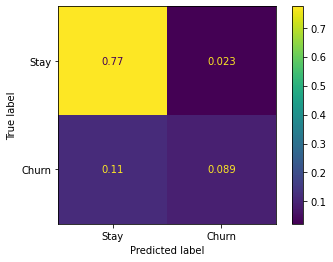


Model LGBMClassifier(random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      2389
           1       0.71      0.39      0.51       611

    accuracy                           0.84      3000
   macro avg       0.78      0.68      0.71      3000
weighted avg       0.83      0.84      0.83      3000

F1 score for test set:0.5068349106203995

CONFUSION MATRIX



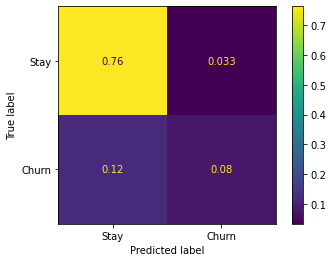

----------------------------------------------



In [34]:
for model in model_list:
    
    pipeline = get_pipeline(transformer=transformer, scaler=scaler_mas, model=model)

    y_pred_train, y_pred_test, model_name = fit_model(pipeline, X_train, X_test, y_train)
    
    print_metrics(model_name, y_pred_train, y_pred_test, y_train, y_test)


- SVC model performance for categorized data has increased (f1 score has nearly doubled, there's also rise in churn recall rate)
- Random Tree based models are slightly less overfitted at the price of lower f1 score
- F1 score for test sets of every model are below 50 %.  <br>

### SMOTE model fitting

SMOTE(k_neighbors=7, random_state=42, sampling_strategy=0.6)
Model LinearSVC(random_state=42) train results:

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      5574
           1       0.49      0.55      0.52      1426

    accuracy                           0.79      7000
   macro avg       0.69      0.70      0.69      7000
weighted avg       0.80      0.79      0.80      7000

F1 score for training set:0.5198003327787022

CONFUSION MATRIX



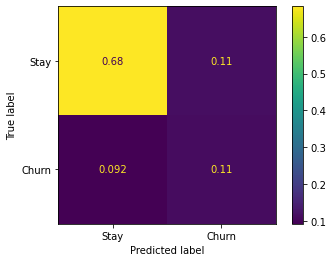


Model LinearSVC(random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      2389
           1       0.53      0.60      0.56       611

    accuracy                           0.81      3000
   macro avg       0.71      0.73      0.72      3000
weighted avg       0.82      0.81      0.81      3000

F1 score for test set:0.5629290617848971

CONFUSION MATRIX



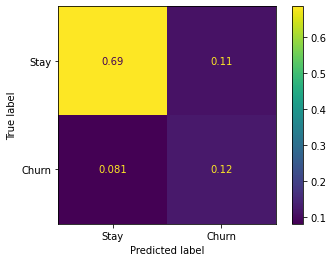

----------------------------------------------

SMOTE(random_state=42, sampling_strategy=0.3)
Model DecisionTreeClassifier(random_state=42) train results:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5574
           1       0.99      0.86      0.92      1426

    accuracy                           0.97      7000
   macro avg       0.98      0.93      0.95      7000
weighted avg       0.97      0.97      0.97      7000

F1 score for training set:0.9222139117427075

CONFUSION MATRIX



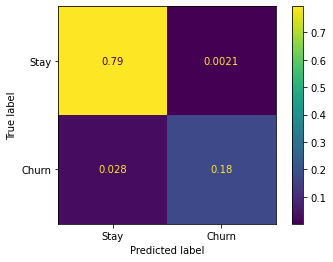


Model DecisionTreeClassifier(random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2389
           1       0.42      0.43      0.42       611

    accuracy                           0.76      3000
   macro avg       0.64      0.64      0.64      3000
weighted avg       0.77      0.76      0.76      3000

F1 score for test set:0.424390243902439

CONFUSION MATRIX



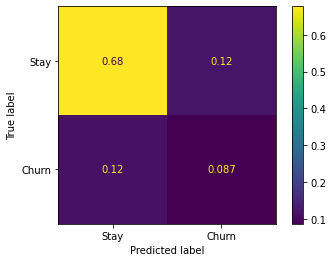

----------------------------------------------

SMOTE(k_neighbors=10, random_state=42, sampling_strategy=0.6)
Model RandomForestClassifier(random_state=42) train results:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5574
           1       0.95      0.90      0.92      1426

    accuracy                           0.97      7000
   macro avg       0.96      0.94      0.95      7000
weighted avg       0.97      0.97      0.97      7000

F1 score for training set:0.9248554913294799

CONFUSION MATRIX



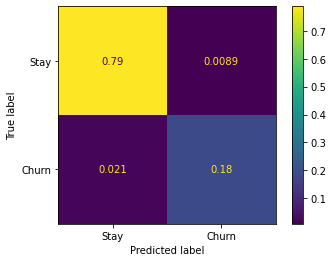


Model RandomForestClassifier(random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      2389
           1       0.58      0.39      0.47       611

    accuracy                           0.82      3000
   macro avg       0.72      0.66      0.68      3000
weighted avg       0.80      0.82      0.80      3000

F1 score for test set:0.4688715953307393

CONFUSION MATRIX



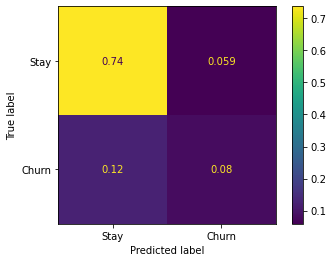

----------------------------------------------

SMOTE(k_neighbors=15, random_state=42, sampling_strategy=0.5)
Model LGBMClassifier(random_state=42) train results:

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      5574
           1       0.79      0.46      0.58      1426

    accuracy                           0.87      7000
   macro avg       0.83      0.71      0.75      7000
weighted avg       0.86      0.87      0.85      7000

F1 score for training set:0.5827050997782706

CONFUSION MATRIX



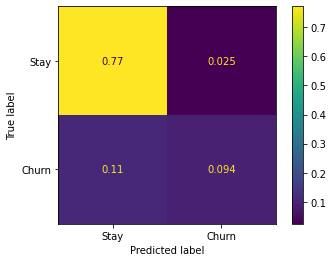


Model LGBMClassifier(random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      2389
           1       0.72      0.40      0.52       611

    accuracy                           0.85      3000
   macro avg       0.79      0.68      0.71      3000
weighted avg       0.83      0.85      0.83      3000

F1 score for test set:0.5178197064989517

CONFUSION MATRIX



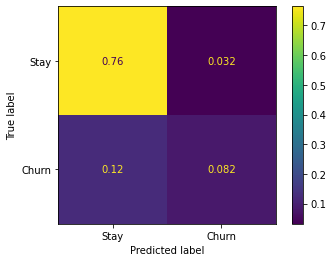

----------------------------------------------



In [35]:
for model in model_list:
    
    pipeline = get_pipeline(transformer=transformer, scaler=scaler_mas, resample = smote, model=model)
    
    smote_Grid = GridSearchCV(pipeline, smote_param_grid, cv=10, scoring="f1", refit=True, n_jobs=-1)
    smote_Grid.fit(X_train, y_train)
    
    best_estimator = smote_Grid.best_estimator_
    
    y_pred_train, y_pred_test, model_name = fit_model(best_estimator, X_train, X_test, y_train)
    
    print(best_estimator.named_steps['resample'])
    print_metrics(model_name, y_pred_train, y_pred_test, y_train, y_test)

- Applying SMOTE rebalance technique resulted in slight increase of SVC model performance.
- No significant change in Decision Tree based classifiers performance.
- Performance of raw data resampled with SMOTE is better than categorized data resampled with SMOTE

### Model fitting with resample

In [36]:
data_majority = data[data["Exited"] == 0]
data_minority = data[data["Exited"] == 1]

majority_samples = int(data["Exited"].value_counts()[0] * 0.7)
minority_samples = int(data["Exited"].value_counts()[1] * 1.3)

In [37]:
data_majority_downsampled = resample(data_majority, 
                                 replace=False,    
                                 n_samples=majority_samples,  
                                 random_state=SEED)

data_minority_upsampled = resample(data_minority, 
                                 replace=True,
                                 n_samples=minority_samples,
                                 random_state=SEED) 
 

# Combine majority class with upsampled minority class
data_resampled = pd.concat([data_majority_downsampled, data_minority_upsampled])
 
# Display new class counts
data_resampled['Exited'].value_counts()

0    5574
1    2648
Name: Exited, dtype: int64

In [38]:
data_resampled = data_resampled.drop(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary'], axis=1)

In [39]:
y_resampled = data_resampled.pop('Exited')
X_resampled = data_resampled

X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test = train_test_split(
 X_resampled, y_resampled, test_size=TEST_SIZE, random_state=SEED, stratify=y_resampled)

Model LinearSVC(random_state=42) train results:

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      3902
           1       0.69      0.51      0.58      1853

    accuracy                           0.77      5755
   macro avg       0.74      0.70      0.71      5755
weighted avg       0.76      0.77      0.76      5755

F1 score for training set:0.5845290081097941

CONFUSION MATRIX



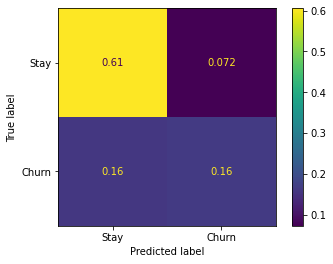


Model LinearSVC(random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1672
           1       0.68      0.50      0.57       795

    accuracy                           0.76      2467
   macro avg       0.73      0.69      0.70      2467
weighted avg       0.75      0.76      0.75      2467

F1 score for test set:0.5747460087082729

CONFUSION MATRIX



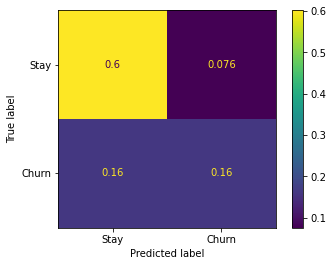

----------------------------------------------

Model DecisionTreeClassifier(random_state=42) train results:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3902
           1       0.97      0.96      0.96      1853

    accuracy                           0.98      5755
   macro avg       0.97      0.97      0.97      5755
weighted avg       0.98      0.98      0.98      5755

F1 score for training set:0.9630233822729743

CONFUSION MATRIX



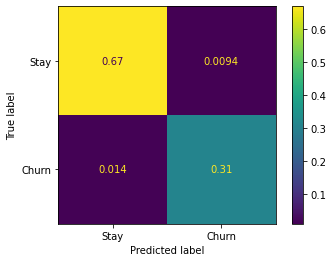


Model DecisionTreeClassifier(random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1672
           1       0.67      0.74      0.70       795

    accuracy                           0.80      2467
   macro avg       0.77      0.78      0.77      2467
weighted avg       0.80      0.80      0.80      2467

F1 score for test set:0.7022168963451167

CONFUSION MATRIX



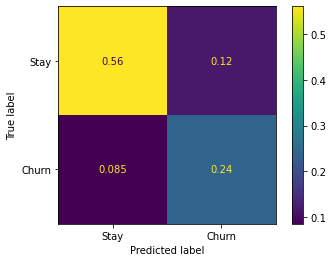

----------------------------------------------

Model RandomForestClassifier(random_state=42) train results:

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3902
           1       0.96      0.97      0.96      1853

    accuracy                           0.98      5755
   macro avg       0.97      0.97      0.97      5755
weighted avg       0.98      0.98      0.98      5755

F1 score for training set:0.9634997316156736

CONFUSION MATRIX



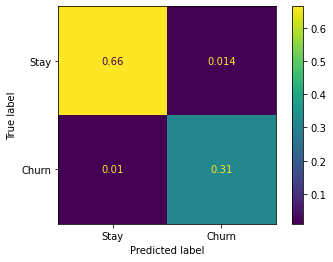


Model RandomForestClassifier(random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      1672
           1       0.76      0.74      0.75       795

    accuracy                           0.84      2467
   macro avg       0.82      0.82      0.82      2467
weighted avg       0.84      0.84      0.84      2467

F1 score for test set:0.7538265306122447

CONFUSION MATRIX



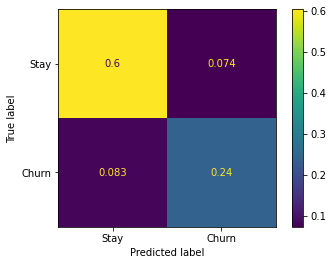

----------------------------------------------

Model LGBMClassifier(random_state=42) train results:

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      3902
           1       0.82      0.66      0.73      1853

    accuracy                           0.84      5755
   macro avg       0.83      0.79      0.81      5755
weighted avg       0.84      0.84      0.84      5755

F1 score for training set:0.7292289300657502

CONFUSION MATRIX



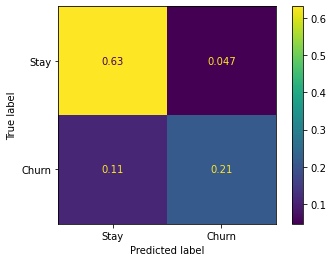


Model LGBMClassifier(random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1672
           1       0.70      0.60      0.65       795

    accuracy                           0.79      2467
   macro avg       0.76      0.74      0.75      2467
weighted avg       0.78      0.79      0.78      2467

F1 score for test set:0.6472184531886025

CONFUSION MATRIX



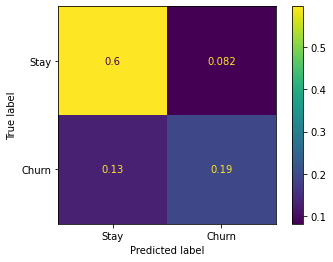

----------------------------------------------



In [40]:
for model in model_list:

    pipeline = get_pipeline(transformer=transformer, scaler=scaler_mas, model=model)
    
    y_pred_train, y_pred_test, model_name = fit_model(pipeline, X_resampled_train, X_resampled_test, y_resampled_train)
    
    print_metrics(model_name, y_pred_train, y_pred_test, y_resampled_train, y_resampled_test)
    

Results are not better than raw data resample model fitting

### Model Optimization

Random Forest Classifier after applying resample function has the best performance with F1 score of 84 % and churn recall score of 82 %.

In [42]:
pipeline = get_pipeline(transformer=clm_transformer, scaler=scaler_mas, model=rfclf)
    
param_grid = {"model__n_estimators":[100, 500, 1000, 1500, 2000],
              "model__max_features":["sqrt", "log2"],
              "model__max_depth":[3, 10, 50, 100, None],
              "model__criterion":["gini", "entropy"],
              "model__min_samples_leaf":[1, 2, 4],
              "model__min_samples_split":[2, 5, 10]
             }
rfclf_Grid = GridSearchCV(pipeline, param_grid, cv=10, scoring="f1", refit=True, n_jobs=-1)
rfclf_Grid.fit(X_resampled_raw_train, y_resampled_raw_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         [1,
                                                                          2])])),
                                       ('resample', None),
                                       ('scaler', MaxAbsScaler()),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [3, 10, 50, 100, None],
                         'model__max_features': ['sqrt', 'log2'],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [100, 500, 1000, 1500, 2000]},
             scoring='f1')

In [43]:
 rfclf_Grid.best_params_

{'model__criterion': 'entropy',
 'model__max_depth': 50,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 1000}

In [44]:
best_estimator = rfclf_Grid.best_estimator_

Model RandomForestClassifier(criterion='entropy', max_depth=50, n_estimators=1000,
                       random_state=42) train results:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3902
           1       1.00      1.00      1.00      1853

    accuracy                           1.00      5755
   macro avg       1.00      1.00      1.00      5755
weighted avg       1.00      1.00      1.00      5755

F1 score for training set:1.0

CONFUSION MATRIX



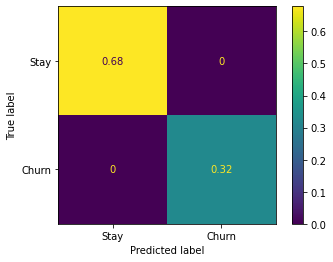


Model RandomForestClassifier(criterion='entropy', max_depth=50, n_estimators=1000,
                       random_state=42) TEST results:

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1672
           1       0.88      0.82      0.85       795

    accuracy                           0.91      2467
   macro avg       0.90      0.89      0.89      2467
weighted avg       0.91      0.91      0.91      2467

F1 score for test set:0.8506493506493507

CONFUSION MATRIX



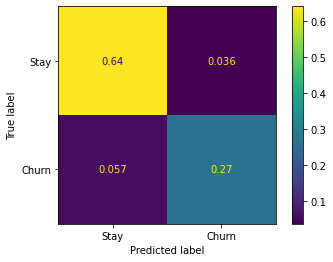

----------------------------------------------



In [45]:
y_pred_train, y_pred_test, model_name = fit_model(best_estimator, X_resampled_raw_train, X_resampled_raw_test, y_resampled_raw_train)
    
print_metrics(model_name, y_pred_train, y_pred_test, y_resampled_raw_train, y_resampled_raw_test) 

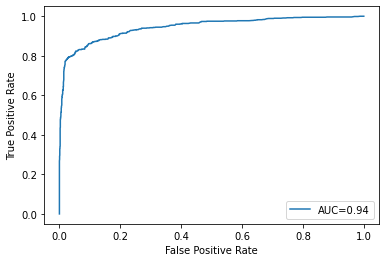

In [46]:
y_pred_proba = best_estimator.predict_proba(X_resampled_raw_test)[::,1]
fpr, tpr, _ = roc_curve(y_resampled_raw_test, y_pred_proba)
auc = round(roc_auc_score(y_resampled_raw_test ,y_pred_proba), 2)

#create ROC curve
plt.plot(fpr,tpr, label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Summary

- Using sklearn resample function to rebalance dataset gave the best improvement of models performance
- In this case categorizing data gave lower results than using uncategorized data
- Random Forrest Classifier had the best score of all tested models
    - f1 score: 85 %
    - AUC: 0.94
    - accuracy 91 %